In [13]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

In [18]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

In [19]:
from matplotlib.colors import ListedColormap

In [21]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [22]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

## Using sklearn: The heights and weights example¶


In [23]:
data = pd.read_csv("01_heights_weights_genders.csv")
data.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [36]:
male = data[data.Gender == 'Male']
female = data[data.Gender == 'Female']

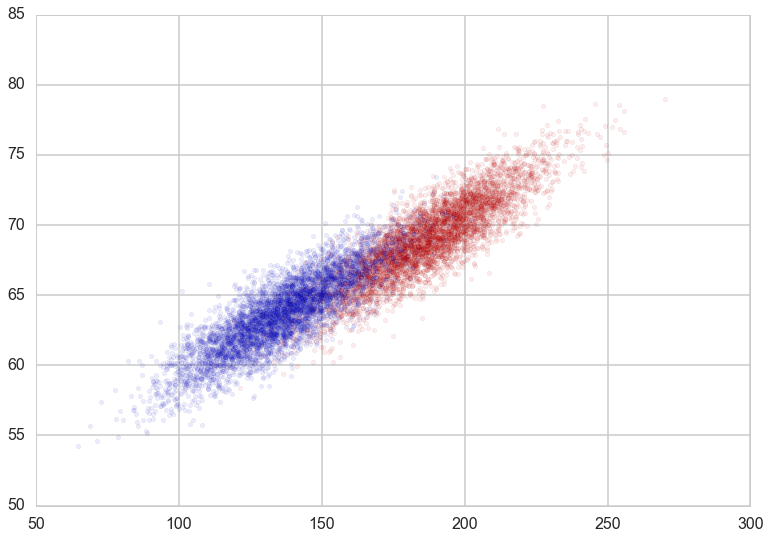

In [40]:
plt.scatter(male.Weight, male.Height, c = cm_bright.colors[0], alpha = 0.08)
plt.scatter(female.Weight, female.Height, alpha = 0.08)

In [83]:
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score
#clf is the classification model.
def cv_score(clf, x, y, score_func=accuracy_score):
    #print (x.size)
    result = 0
    nfold = 5
    #here the actuall crossvalidation is taking place.
    #and the test here is actually validation set, Kfold does all our work.
    for train, test in KFold(y.size, nfold):# split data into train/test groups, 5 times
        clf.fit(x[train], y[train])# fit
        result += score_func(clf.predict(x[test]), y[test])# evaluate score function on held-out data
    return result/nfold# average

In [90]:
from sklearn.cross_validation import train_test_split
#here we split the data in actual train and test data.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(data[['Height','Weight']].values, (data.Gender=="Male").values)
#print (Xlr.size, Xtestlr.size, ylr.size, ytestlr.size)
Xlr

array([[  67.93499042,  182.2710213 ],
       [  69.80157523,  203.2583751 ],
       [  69.98313746,  206.41441183],
       ..., 
       [  64.94254533,  135.38715381],
       [  63.55635371,  134.75059409],
       [  61.82336812,  112.00186173]])

0.9208 0.001


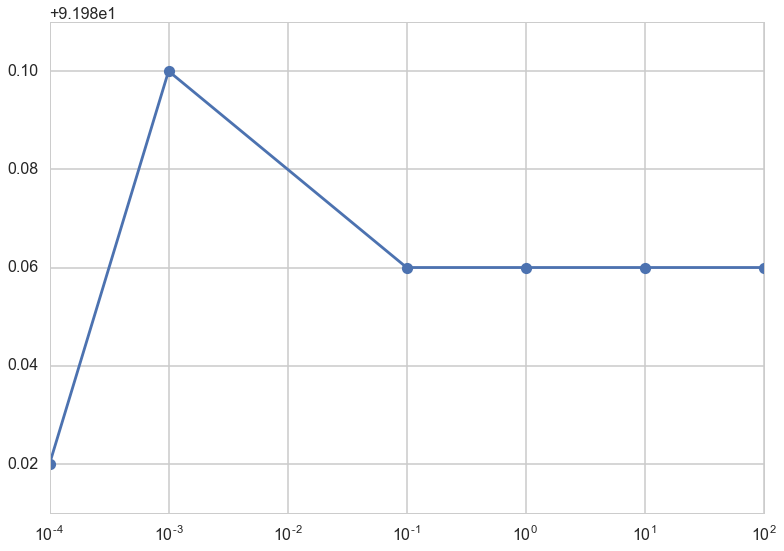

In [130]:
#the grid of parameters to search over
Cs = [0.0001, 0.001, 0.1, 1, 10, 100]
from sklearn.linear_model import LogisticRegression
max_score = 0
scores = []
for C in Cs:
    clf = LogisticRegression(C = C)
    score = cv_score(clf, Xlr, ylr)
    scores.append(score * 100)
    if(score > max_score):
        max_score = score
        best_C = C
plt.plot(Cs, scores, 'o-')
plt.xscale('log')
print (max_score, best_C)

In [131]:
clf = LogisticRegression(C = best_C)
clf.fit(Xlr, ylr)
accuracy = accuracy_score(clf.predict(Xtestlr), ytestlr)
accuracy

0.91479999999999995

Hence our model predicts the data with nearly 92.12% accuracy

## This is a direct way to do the above things

In [132]:
from sklearn.grid_search import GridSearchCV
clf2 = LogisticRegression()
params = {"C" : [0.0001, 0.001, 0.1, 1, 10, 100]}
fit_model = GridSearchCV(clf2, param_grid = params, cv = 5, scoring = "accuracy")
fit_model.fit(Xlr, ylr)
fit_model.best_estimator_, fit_model.best_params_, fit_model.best_score_, fit_model.grid_scores_

(LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 {'C': 0.001},
 0.92053333333333331,
 [mean: 0.91987, std: 0.00605, params: {'C': 0.0001},
  mean: 0.92053, std: 0.00726, params: {'C': 0.001},
  mean: 0.92013, std: 0.00699, params: {'C': 0.1},
  mean: 0.92013, std: 0.00699, params: {'C': 1},
  mean: 0.92013, std: 0.00699, params: {'C': 10},
  mean: 0.92013, std: 0.00699, params: {'C': 100}])

In [133]:
clfl2=LogisticRegression(C=fit_model.best_params_['C'])
clfl2.fit(Xlr, ylr)
score = accuracy_score(clfl2.predict(Xtestlr), ytestlr)
score

0.91479999999999995

## The ATM Camera example


In [152]:
data=np.load("imag.pix.npy")
y=np.load("imag.lbl.npy")
print ("The number of images in the database are", data.size / 132342)
#132342 are the number of features in the image.
STANDARD_SIZE = (322, 137)#standardized pixels in image.
#y tells whether the image is a bill or a cheque
data.shape, y.shape

The number of images in the database are 87.0


((87, 132342), (87,))

In [154]:
def get_image(mat):
    size = STANDARD_SIZE[0]*STANDARD_SIZE[1]*3
    r,g,b = mat[0:size:3], mat[1:size:3],mat[2:size:3]
    rgbArray = np.zeros((STANDARD_SIZE[1],STANDARD_SIZE[0], 3), 'uint8')#3 channels
    rgbArray[..., 0] = r.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 1] = b.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 2] = g.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    return rgbArray

def display_image(mat):
    with sns.axes_style("white"):
        plt.imshow(get_image(mat))
        plt.xticks([])
        plt.yticks([])

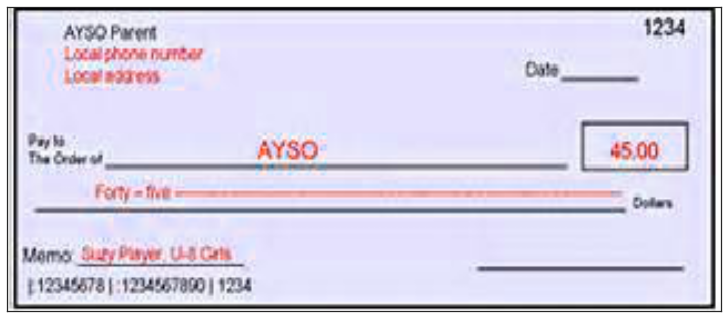

In [155]:
display_image(data[5])

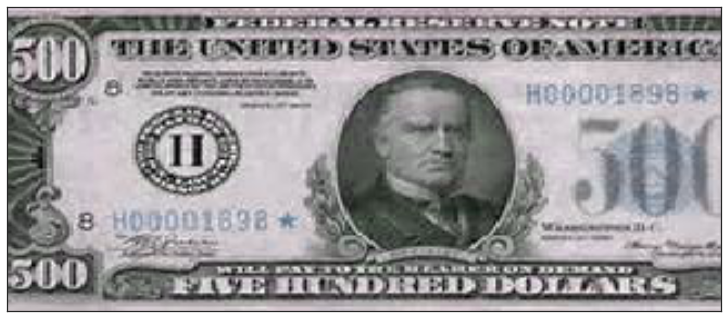

In [156]:
display_image(data[50])

## The curse of dimensionality: Feature engineering

The first thing that you notice is that you have many many features: to be precise, 322x137x3=136452 of them. This is a lot of features! Having too many features can lead to overfitting.

You have seem this before! Remember when we did the polynomial regression? When we tried to find fits in 1, there were two features, the constant, and x. In 2, there are 3: the constant, x, and x2. When we get to 20, there are 21: the constant, and 20 powers of x. And then we saw how regularization tried to eliminate some of these powers by sending their co-efficients in the polynomial very close to 0, thus reducing the number of features we had.

Another way to look at this problem is the following: we have 85 data points, but 136452 features; that is, way more features than data points. Thus there is a high chance that a few attributes will correlate with y purely coincidentally! [^Having lots of images, or "big-data" helps in combatting overfitting!]

We need to do something similar to what happened in the regularized regression here! We will engage in some a-priori feature selection that will reduce the dimensionality of the problem. The idea we'll use here is something called Principal Components Analysis, or PCA.

PCA is an unsupervized learning technique. The basic idea behind PCA is to rotate the co-ordinate axes of the feature space. We first find the direction in which the data varies the most. We set up one co-ordinate axes along this direction, which is called the first principal component. We then look for a perpendicular direction in which the data varies the second most. This is the second principal component. The diagram illustrates this process. There are as many principal components as the feature dimension: all we have done is a rotation.

In [167]:
#playing around
xtrain, xtest, ytrain, ytest = train_test_split(data, y, test_size = 0.33)

In [168]:
#playing around
clf = LogisticRegression(C = 0.001)
clf.fit(xtrain, ytrain)
score = accuracy_score(clf.predict(xtest), ytest)
score

0.89655172413793105

In [180]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 60)
X = pca.fit_transform(data)
X

array([[ -2.25363626e+04,   2.42834397e+03,   2.13377724e+03, ...,
         -1.12364944e+02,  -1.86038429e+02,  -6.83309891e+01],
       [ -2.22266587e+04,   7.09255778e+02,   2.88826225e+02, ...,
          8.65498759e+01,  -6.82536062e+01,   1.94165434e+02],
       [ -1.73642608e+04,   4.25202715e+03,  -7.93802239e+02, ...,
         -4.22350399e+02,  -1.36714737e+03,  -8.22139175e+02],
       ..., 
       [  1.24430482e+04,   3.41227800e+03,  -7.42024404e+00, ...,
          7.76969774e+02,  -2.04011392e+02,   1.30323823e+02],
       [  1.16549277e+04,   2.37596720e+03,   4.58184737e+03, ...,
          4.54376223e+03,   1.59726094e+02,   1.06041900e+03],
       [  5.84668690e+03,   1.73120853e+03,   3.69687535e+03, ...,
         -1.01260996e+03,  -6.37096643e+02,   2.46938979e+03]])

In [186]:
print (type(pca))
pca.explained_variance_ratio_.sum()

<class 'sklearn.decomposition.pca.PCA'>


0.94287952861675539

## WOW
The explained variance ratio pca.explained_variance_ratio_ tells us how much of the variation in the features is explained by these 60 features. When we sum it up over the features, we see that 94% is explained: good enough to go down to a 60 dimensional space from a 136452 dimensional one!

In [195]:
df = pd.DataFrame({"y":y, "label" : np.where(y == 1, "check", "dollar")})
for i in range(X.shape[1]):
    df["pc%i" % (i+1)] = X[:, i]
pca.components_.shape

(60, 132342)

In [187]:
def normit(a):
    a=(a - a.min())/(a.max() -a.min())
    a=a*256
    return np.round(a)
def get_nc(pca, j):
    size = 322*137*3
    r = pca.components_[j][0:size:3]
    g = pca.components_[j][1:size:3]
    b = pca.components_[j][2:size:3]
    r=normit(r)
    g=normit(g)
    b=normit(b)
    return r,g,b
def display_component(pca, j):
    r, g, b = get_nc(pca, j)
    rgbArray = np.zeros((137,322,3), 'uint8')
    rgbArray[..., 0] = r.reshape(137,322)
    rgbArray[..., 1] = g.reshape(137,322)
    rgbArray[..., 2] = b.reshape(137,322)
    plt.imshow(rgbArray)
    plt.xticks([])
    plt.yticks([])

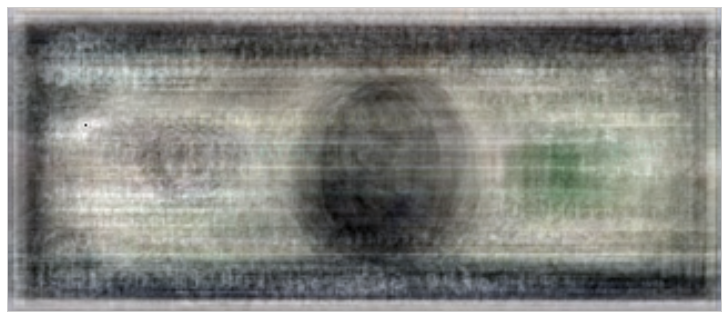

In [196]:
display_component(pca, 0)

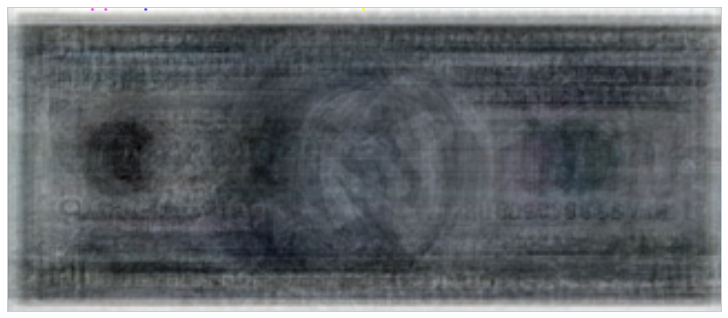

In [199]:
display_component(pca, 1)

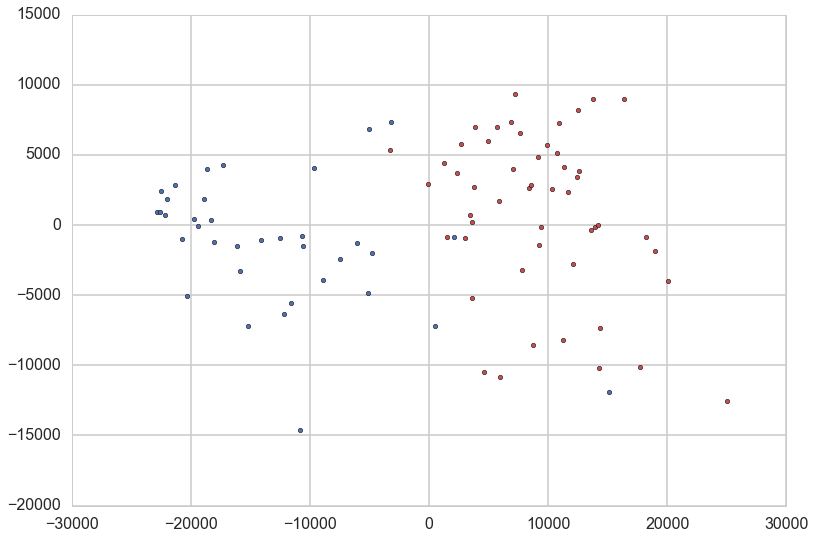

In [207]:
colors = [c0, c2]
for label, color in zip(df['label'].unique(), colors):
    mask = (df['label'] == label)
    plt.scatter(df[mask]['pc1'], df[mask]['pc2'], c = color, label = label)

## Using kNN to fit the data 

In [217]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
#we'll split the data on the basis of these values
ys=df['y'].astype(int).values
subdf=df[['pc1','pc2']]
Xs=subdf.values
def classify(X, y, nbrs, plotit=True, train_size=0.6):
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, train_size = train_size)
    clf = KNeighborsClassifier(nbrs)
    clf = clf.fit(Xtrain, Ytrain)
    #in sklearn accuracy can be found by using "score". It predicts and then gets the accuracy
    training_accuracy = clf.score(Xtrain, Ytrain)
    testing_accuracy = clf.score(Xtest, Ytest)
    Xall=np.concatenate((Xtrain, Xtest))
    if plotit:
        print ("Accuracy on training data: %0.2f" % (training_accuracy))
        print ("Accuracy on test data:     %0.2f" % (testing_accuracy))
        plt.figure()
        ax=plt.gca()
        points_plot(ax, Xtrain, Xtest, ytrain, ytest, clf, alpha=0.3, psize=20, predicted=True)
    return nbrs, training_accuracy, testing_accuracy

Lets see what happens when we choose k=1. On the training set, the 1NN classifier memorizes the training data. It will predict perfectly on the training set, and wont do too badly on the test set, especially deep in the regions of feature space where one or the other class dominates. This is because evem one neighbor might be enough in those regions. However, the same classifier will do badly near the clasification boundaries on the test set, because you will need more than one neighbor to decide with any certainty of the class.

The result of this is, as you might expect, the regions of feature space classfied one way or the other (blue is check, red is dollar) are quite jagged and mottled. Since we are choosing just one neighbor, we fit to the noise in the region rather than the trend. We are overfitting.

Accuracy on training data: 1.00
Accuracy on test data:     0.89


(1, 1.0, 0.88571428571428568)

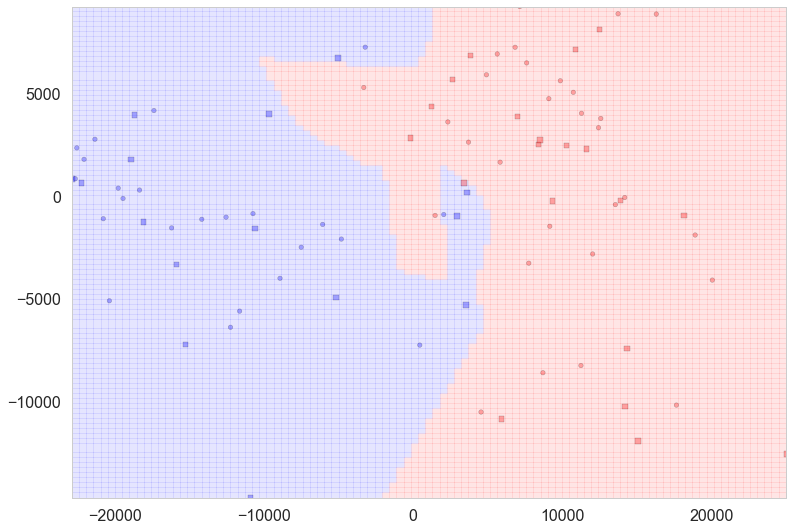

In [223]:
classify(Xs,ys,1)


Accuracy on training data: 0.56
Accuracy on test data:     0.63


(50, 0.55769230769230771, 0.62857142857142856)

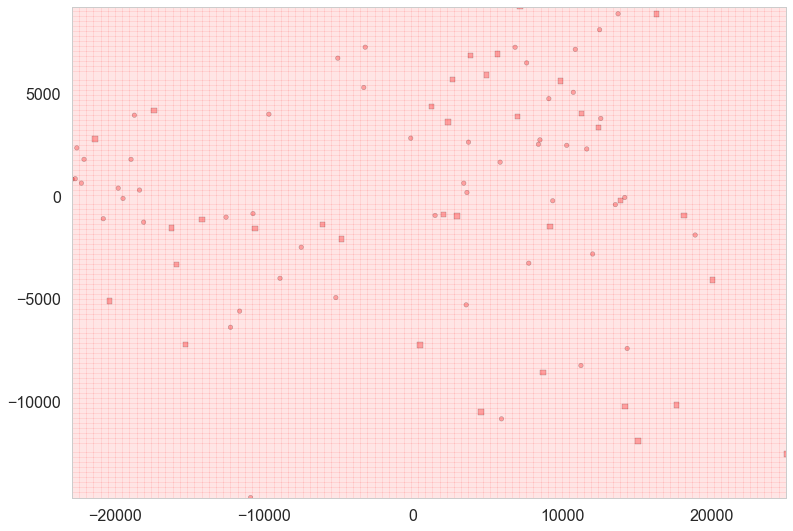

In [228]:
classify(Xs,ys,50)

In [ ]:
fits = {}
#fit the model using the same number of neighbours 200 times to get a better estimate
for k in np.arange(1, 45, 1):
    fits[k] = []
    for i in range(200):
        fits[k].append(classify(Xs, ys,k, False))
nbrs=np.arange(1,45,1)
        